# Comparison of scenarios

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import os

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
when = 'future'
file_prefix = f'week'
outdir = '2021-01-19-107_90/'

n_int_steps = 6
nnodes = 107  # nodes
ndays_ocp = 90
ndays = 90

setup = ItalySetup(nnodes, ndays, when)
setup_ocp = ItalySetup(nnodes, ndays_ocp, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)
    
scenarios = {pick_scenario(setup, i)['name']:pick_scenario(setup, i) for i in np.arange(16)}
scenarios.keys()

Loaded Italy Setup with 107 nodes.
Loaded Italy Setup with 107 nodes.


dict_keys(['U-r3-t479700-id0', 'L-r3-t479700-id1', 'U-r15-t125000-id2', 'L-r15-t125000-id3', 'U-r15-t250000-id4', 'L-r15-t250000-id5', 'U-r15-t479700-id6', 'L-r15-t479700-id7', 'U-r15-t1000000-id8', 'L-r15-t1000000-id9', 'U-r15-t1500000-id10', 'L-r15-t1500000-id11', 'U-r15-t2000000-id12', 'L-r15-t2000000-id13', 'U-r150-t479700-id14', 'L-r150-t479700-id15'])

In [69]:
summary = pd.read_csv('model_output/2021-02-19/all_summary.csv', index_col=0)
summary['method_str'] = summary['method']
summary['method'].replace('opi', 'Optimal', inplace=True)
summary['method'].replace('pinc', 'Incidence', inplace=True)
#summary.replace('cas', 'Future Incidence', inplace=True)
summary['method'].replace('ppop', 'Population', inplace=True)
summary['method'].replace('psus', 'Susceptibility', inplace=True)
summary.replace('U', 'Pessimistic', inplace=True)
summary.replace('L', 'Optimistic', inplace=True)
summary.reset_index(inplace=True, drop=True)

In [86]:
import tqdm
summary['averted-rel'] = 0
summary_opt = summary[summary['method']=='Optimal']
for i, row in tqdm.tqdm(summary.iterrows()):
    summary.loc[i,'averted-rel'] = summary.loc[i,'averted']/float(summary_opt[(summary_opt['post_sample']== summary.loc[i,'post_sample']) & 
            (summary_opt['scenario-beta']== summary.loc[i,'scenario-beta'])& 
            (summary_opt['scenario-rate']== summary.loc[i,'scenario-rate'])
           & (summary_opt['scenario-tot']== summary.loc[i,'scenario-tot'])]['averted'].values)

17952it [00:28, 634.55it/s]


In [92]:
import tqdm
summary['averted-rel2'] = 0
summary_opt = summary[(summary['method']=='Optimal') & (summary['post_sample']== 101)]
for i, row in tqdm.tqdm(summary.iterrows()):
    summary.loc[i,'averted-rel2'] = summary.loc[i,'averted']/float(summary_opt[
            (summary_opt['scenario-beta']== summary.loc[i,'scenario-beta'])& 
            (summary_opt['scenario-rate']== summary.loc[i,'scenario-rate'])
           & (summary_opt['scenario-tot']== summary.loc[i,'scenario-tot'])]['averted'].values)

17952it [00:20, 891.29it/s]


In [94]:
summary['averted-rel2'] = summary['averted-rel2']*100

In [105]:
summary['averted-rel'] = summary['averted-rel']*100

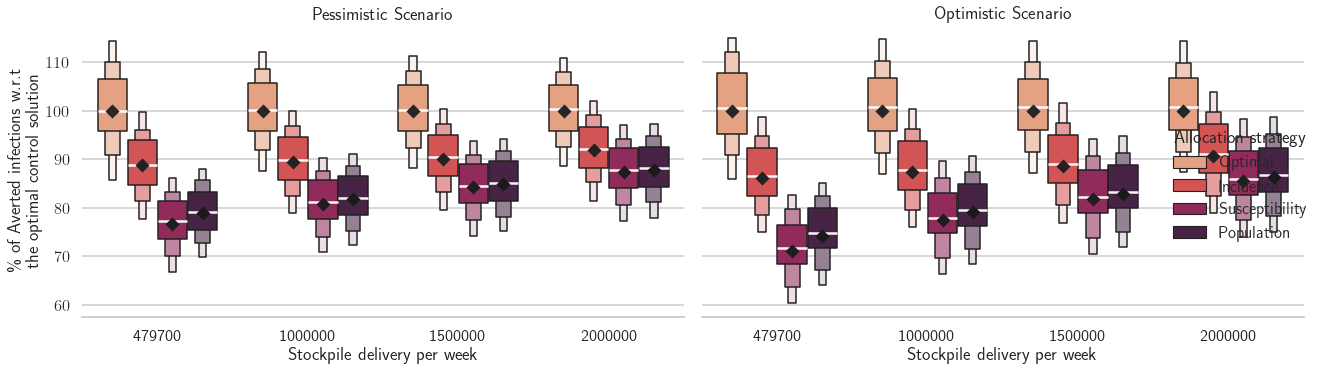

In [114]:
methods = ['opi', 'finc', 'pinc', 'fsus', 'psus','fincpp', 'pincpp', 'fsuspp', 'psuspp', 'ppop', 'fpop']
#methods = ['opi', 'finc','fincpp', 'pincpp']
methods = ['opi', 'pinc','ppop', 'psus']

toplot = "averted-rel2"
#var_x = "scenario-rate"  
var_x = "newdoseperweek" 

dpw = summary['newdoseperweek'].unique()

dpw = [ 479700, 1000000, 1500000, 2000000]

#smry = summary[(summary['scenario-tot']=='t479700') & (summary['method'].isin(methods))]


smry = summary[(summary['scenario-rate']=='r15') & (summary['method_str'].isin(methods)) & (summary['newdoseperweek'].isin(dpw))]
sns.set_theme(style="whitegrid")
sns.set_context("talk")
mpl.rc('text', usetex=True)
#mpl.rc('font', size=25)
#mpl.rc('legend', fontsize=24)


grid = sns.FacetGrid(smry, col="scenario-beta",  palette="mako", height=5.5, aspect = 1.5, col_wrap=2, sharey=True,sharex=True)
def quantile_plot(index, reduction, method, scn_beta, **kwargs):

    g = sns.boxenplot(
            #data=smry,,
            x=index, y=reduction,
            hue=method,
            palette="rocket_r",
            dodge=9,
            #size=2,
            #alpha = .4,
            #inner="stick"
            showfliers=False,
        
        )
    ax = plt.gca()
    #ax.set_ylim(0)
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")
    plt.legend()
    
    for line in ax.get_lines():
        line.set_color('white')
        line.set_linewidth(2.5)
        line.set_alpha(10)
    



# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, var_x, toplot, "method", "scenario-beta")#, marker="o")

grid.add_legend(title='Allocation strategy')


def quantile_plot(index, reduction, method, scn_beta, **kwargs):
    g2 = sns.stripplot(
        x=var_x,
        y=toplot,
        data = smry[(smry['post_sample']==101) & (smry['scenario-beta']==scn_beta.unique()[0])], 
        dodge=.63, 
        hue="method",
        jitter=False,
        #ax = ax,
       color = 'k',
        #palette="husl",
        marker="D",   # passed to https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter
        s=10, 
        linewidths = 10,
        edgecolors = 'k',
        zorder=100000,
    )
grid.map(quantile_plot, "newdoseperweek", toplot, "method", "scenario-beta")#, marker="o")


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        
# Adjust the arrangement of the plots
#grid.fig.suptitle(run_name)
grid.despine(left=True)

#grid.set_axis_labels("Stockpile delivery per week","Averted infections after 90 days",)
grid.set_axis_labels("Stockpile delivery per week","\% of Averted infections  w.r.t  \n the optimal control solution",)
grid.set_titles(col_template="{col_name} Scenario", row_template="{row_name}")
grid.fig.tight_layout(w_pad=1)
grid.fig.savefig(f'figures/scenarios_perturb_all.pdf')

In [55]:
methods = ['opi', 'finc', 'pinc', 'fsus', 'psus','fincpp', 'pincpp', 'fsuspp', 'psuspp', 'ppop', 'fpop']

dpw = summary['newdoseperweek'].unique()
dpw = [ 479700, 1000000, 1500000, 2000000]
smry = summary[(summary['scenario-rate']=='r15') & (summary['method_str'].isin(methods)) & (summary['newdoseperweek'].isin(dpw))]

sm = smry[smry['scenario-beta']=='Pessimistic']
for sample in sm['post_sample'].unique():
    for ndpw in  sm['newdoseperweek'].unique():
        a = sm[(sm['post_sample'] == sample) & (sm['newdoseperweek'] == ndpw)]
        a = a.sort_values('averted', ascending=False)
        if (a.iloc[0]['method'] is not 'Optimal'):
            print(sample, ndpw, a.iloc[0]['method'] )
sm = smry[smry['scenario-beta']=='Optimistic']
for sample in sm['post_sample'].unique():
    for ndpw in  sm['newdoseperweek'].unique():
        a = sm[(sm['post_sample'] == sample) & (sm['newdoseperweek'] == ndpw)]
        a = a.sort_values('averted', ascending=False)
        if (a.iloc[0]['method'] is not 'Optimal'):
            print(sample, ndpw, a.iloc[0]['method'] )
            


In [46]:
filename = 'model_output/scenarios_102_90/L-r15-t479700-id7-opi-107_90.csv'
#filename = 'helvetios-runs/2021-02-15-107_90/week-L-r150-t479700-id11-opt-107_90.csv'
mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, pick_scenario(setup, int(filename.split('-')[-3][2:])))
mydata[mydata['comp']=='yell'].sum()['value']

245109.2340726376

In [47]:
filename = 'model_output/scenarios_102_90/L-r15-t479700-id7-fincpp-107_90.csv'
mydata = pd.read_csv(filename, index_col= 'date', parse_dates=True)
maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, pick_scenario(setup, int(filename.split('-')[-3][2:])))
mydata[mydata['comp']=='yell'].sum()['value']

254720.32989864826

In [16]:
summary[(summary['post_sample']==101) & (summary['scenario-rate']=='r15') & (summary['newdoseperweek']==479700) & (summary['scenario-beta']=='Optimistic')].sort_values('averted', ascending=False)


,newdoseperweek,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,bl,averted,avertedpervacc
101,479700,opi,8.616819e+07,101.0,6.236100e+06,Optimistic,r15,t479700,L-r15-t479700-id7,8.817886e+07,2.010679e+06,0.322426
101,479700,pinc,8.644766e+07,101.0,6.238414e+06,Optimistic,r15,t479700,L-r15-t479700-id7,8.817886e+07,1.731203e+06,0.277507
101,479700,pincpp,8.645119e+07,101.0,6.239378e+06,Optimistic,r15,t479700,L-r15-t479700-id7,8.817886e+07,1.727672e+06,0.276898
101,479700,fincpp,8.664006e+07,101.0,6.236100e+06,Optimistic,r15,t479700,L-r15-t479700-id7,8.817886e+07,1.538807e+06,0.246758
101,479700,finc,8.664182e+07,101.0,6.236100e+06,Optimistic,r15,t479700,L-r15-t479700-id7,8.817886e+07,1.537047e+06,0.246476
101,479700,ppop,8.668635e+07,101.0,6.238393e+06,Optimistic,r15,t479700,L-r15-t479700-id7,8.817886e+07,1.492516e+06,0.239247
101,479700,fpop,8.668716e+07,101.0,6.236100e+06,Optimistic,r15,t479700,L-r15-t479700-id7,8.817886e+07,1.491708e+06,0.239205
101,479700,fsus,8.669935e+07,101.0,6.236100e+06,Optimistic,r15,t479700,L-r15-t479700-id7,8.817886e+07,1.479510e+06,0.237249
101,479700,fsuspp,8.671517e+07,101.0,6.236100e+06,Optimistic,r15,t479700,L-r15-t479700-id7,8.817886e+07,1.463693e+06,0.234713
101,479700,psus,8.675124e+07,101.0,6.238393e+06,Optimistic,r15,t479700,L-r15-t479700-id7,8.817886e+07,1.427623e+06,0.228845


In [ ]:
smry = summary[(summary['scenario-rate']=='r15')]

grid = sns.FacetGrid(smry, col="scenario-beta",  palette="mako", height=8.5, aspect = 1.5, col_wrap=2, sharey=False,sharex=True)
def quantile_plot(index, reduction, method, scn_beta, **kwargs):
    g = sns.boxenplot(
        #data=smry,,
        x=index, y=reduction,
        hue=method,
        palette="husl",
        dodge=9,
        #size=2,
        #alpha = .4,
        #inner="stick"
        showfliers=False
    )
    ax = plt.gca()
    ax.set_ylim(0)
    g.legend(True)

    g2 = sns.pointplot(x="newdoseperweek", y="avertedpervacc",
          data = smry[(smry['post_sample']==64) & (smry['scenario-beta']==scn_beta.unique()[0])], 
          dodge=.60, 
          join=False, 
          #palette="cool",
          hue="method",
          #palette="husl",
                       color = 'black',
          markers="D", 
          scale=1, 
          ci=None,
          zorder=100000,
                       edgecolor='black',
                       hatch = "|",
                        linewidth=3,
                       markeredgewidth=4, #markeredgecolor=(1, 1, 1, 0)
          #legend=True
         )
    
    #sns.violinplot(x=index, y=reduction, #hue="geoid",
    #               dodge=True,  zorder=1)#Ç, scale='width')#, alpha=.25,capsize=.8, size = .2, errwidth=.75);
    #sns.pointplot(x="index", y="reduction", data = npi_truth[npi_truth['geoid']==kwargs['label']], dodge=.532, join=False, #palette="dark",
    #          markers="d", scale=1.75, ci=None,zorder=102, color="black")
    #plt.scatter((1,1),  **kwargs)

# Draw a line plot to show the trajectory of each random walk
#grid.map(sns.violinplot, 'index', "reduction" )#, marker="o")
grid.map(quantile_plot, "newdoseperweek", "avertedpervacc", "method", "scenario-beta") #, marker="o")


for ax in grid.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        
# Adjust the arrangement of the plots
#grid.fig.suptitle(run_name)
grid.despine(left=True)

grid.set_axis_labels("Averted infection per dose", "New doses available, per week")
grid.set_titles(col_template="Scenario: {col_name}", row_template="{row_name}")
#grid.add_legend()
grid.fig.tight_layout(w_pad=1)
grid.fig.savefig(f'figures/scenarios_perturb_all.pdf')

In [61]:
smry[smry['avertedpervacc'] < 0]

,newdoseperweek,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,bl,averted,avertedpervacc


In [213]:
sn

NameError: name 'sn' is not defined

In [23]:
scn = 'L'
smry = summary[(summary['scenario-rate']=='r15') & (summary['scenario-beta']==scn)]

sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':100})
sns.set_theme(style="whitegrid")
sns.set_context("talk")

g = sns.catplot(
    data=smry,
    kind="boxen",
    x="newdoseperweek",
    y="avertedpervacc", 
    hue="method",
    palette="rocket",
    dodge=.59,
    height=8,
    #alpha = .4,
    #inner="stick"
    legend=False,
    showfliers=False
)
g2 = sns.pointplot(x="newdoseperweek",
              y="avertedpervacc", 
              data = smry[smry['post_sample']==64], 
              dodge=.59, 
              join=False, 
              #palette="cool",
              hue="method",
              palette="mako_r",
              markers="d", 
              scale=1.25, 
              ci=None,
              zorder=100000,
              #legend=False
             )

plt.setp(g.ax.lines, zorder=100)
plt.setp(g.ax.collections, zorder=100, label="")
g.despine(left=True)
g.set_axis_labels("Dose per week", "Averted Cases per dose")
#g2.legend.set_title("Allocation")


g.fig.savefig(f'figures/scenarios_perturb{scn}.pdf')

,newdoseperweek,method,infected,post_sample,doses,scenario-beta,scenario-rate,scenario-tot,scenario,bl,averted,avertedpervacc
64,125000,opi,9.801593e+08,64.0,1.625000e+06,U,r15,t125000,U-r15-t125000-id4,1.013345e+09,3.318549e+07,20.421839
64,250000,opi,9.527705e+08,64.0,3.250000e+06,U,r15,t250000,U-r15-t250000-id10,1.013345e+09,6.057431e+07,18.638251
64,479700,opi,9.106863e+08,64.0,6.236100e+06,U,r15,t479700,U-r15-t479700-id16,1.013345e+09,1.026585e+08,16.461971
64,1000000,opi,8.382537e+08,64.0,1.297121e+07,U,r15,t1000000,U-r15-t1000000-id22,1.013345e+09,1.750910e+08,13.498432
64,2000000,opi,7.420616e+08,64.0,2.491384e+07,U,r15,t2000000,U-r15-t2000000-id28,1.013345e+09,2.712832e+08,10.888853
64,125000,cas,9.926378e+08,64.0,1.608347e+06,U,r15,t125000,U-r15-t125000-id4,1.013345e+09,2.070701e+07,12.874710
64,250000,cas,9.719664e+08,64.0,3.216392e+06,U,r15,t250000,U-r15-t250000-id10,1.013345e+09,4.137836e+07,12.864836
64,479700,cas,9.367470e+08,64.0,6.159978e+06,U,r15,t479700,U-r15-t479700-id16,1.013345e+09,7.659775e+07,12.434743
64,1000000,cas,8.678225e+08,64.0,1.267881e+07,U,r15,t1000000,U-r15-t1000000-id22,1.013345e+09,1.455223e+08,11.477598
64,2000000,cas,7.611833e+08,64.0,2.486851e+07,U,r15,t2000000,U-r15-t2000000-id28,1.013345e+09,2.521615e+08,10.139789
